# Bayes A/B Hypothesis Testing

> This notebook describes how to implement [Bayes A/B Testing](https://en.wikipedia.org/wiki/Bayesian_inference) in Python. I created this based on Bogdan Kulynych's [excellent presentation](https://www.youtube.com/watch?v=8DMU9h4dwi8) at PyConPl14.

Bayes A/B is a replacement for the traditional statistical testing commonly referred to as [Null Hypothesis Testing (NHT)](https://en.wikipedia.org/wiki/Null_hypothesis). 

So let's say we want to compare two things. For example, we have two sets of advertisements on a webpage (or two medical treatments for cancer or a product from two different assembly lines). We ask the question: "Is there a difference between group A and group B?" That's where the A/B comes from.

With traditional statistics, we would perform a [t-test](https://en.wikipedia.org/wiki/Student's_t-test) on the two datasets based on the difference in their sample means divided by their sample standard deviation. Or, in our case of click rates for two advertisements, we'd use the [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) which handles discrete valued datasets ("clicks" versus "not clicked" ads).

However, over the last few decades there's been a growing [rift](https://conversionxl.com/bayesian-frequentist-ab-testing/) among statisticians. Bayesians-- the fanboys of Bayes A/B say that Frequentists-- the fanboys of NHT-- are going about it backward. I sum up the whole controversy by stating:

$$p(d \mid H_0) \neq p(H_0 \mid d)$$

NHT gives you p-values. p-values are the probability of getting this set of data given the null hypothesis is true, $p(d \mid H_0)$. So if p < 0.05, then there is a 5% chance of getting this data from a world in which the null hypothesis is true. Hence, we should clearly reject the null hypothesis given this highly unlikely dataset. However, most people confuse this by saying that "There's a 95% chance that the null hypothesis is false."  In other words, they are assuming that $p(H_0 \mid d) = (1 - \text{p_value})$. That's plain wrong. The test is only stating the probability of getting **this data** given the assumption that the null hypothesis is true. So what we really want to know is the converse: "What is the probability that **the null hypothesis** is true (or false) given this data, $p(H_0 \mid d)$. 

That's where Bayes theorem comes in. Bayes relates the two probabilities:

$$p(H_0 \mid d) = \frac{p(d \mid H_0)p(H_0)}{p(d)}$$

With Bayes, we can go from one conditional probability to the other (note: that the only way they are equal is if the probability of the data is equal to the probability that the null hypothesis is true ($p(d) = p(H_0)$). With Bayes we can finally answer the actual problem we want to solve-- is there a difference between treatment/group A and B?

So in my mind, Bayes A/B testing is the right test for the job. Most of the questions ask about our data-- how confident are we that there's a difference, how confident are we that the difference is at least $X$ units-- can be answered by Bayes in a more straightforward manner. Plus, it allows for online updating of our decisions as new data comes in.

## Let's import numpy, matplotlib, and scipy stats libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

%matplotlib inline

## Setting up the Data Variables
### Click data for 2 ads

Setting up for Bayes is very simple. This is just a simple dictionary (or dictionary of dictionaries). So each ad has an ID, a number of times viewed, and a number of times clicked.

In [2]:
data = {
'ad1' : {'views' : 42, 'clicks' : 2},
'ad2' : {'views' : 85, 'clicks' : 11 }
}

## So here's the conventional calculation

In [3]:
print('ad1 was clicked %.2f%% of the time'%(data['ad1']['clicks'] *1.0/ data['ad1']['views'] * 100))

print('ad2 was clicked %.2f%% of the time'%(data['ad2']['clicks'] *1.0 / data['ad2']['views'] * 100))

print('ad2 was definitely click more frequently. But is it statistically significant?')

ad1 was clicked 4.76% of the time
ad2 was clicked 12.94% of the time
ad2 was definitely click more frequently. But is it statistically significant?


## [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)

Chi-squared is the basic NHT test for statistical significance in categorical (discrete valued) data. It just uses a simple table. So in our case, it is a matrix with two rows and two columns. The first row is the "observed" data (which I set as ad2). The second is the "expected" data (which I set to ad1). The columns are "clicked" and "not clicked". Chi-squared is really just the sum of the squared errors divided by the expected value.

|          | Clicked | Not Clicked |   
|----------|---------|-------------|
| *Observed Values* | 11      | 74          | 
| *Expected Values* | 2       | 40          | 


In [4]:
observed = [data['ad2']['clicks'], (data['ad2']['views'] - data['ad2']['clicks']) ] # clicks, not clicks
expected = [data['ad1']['clicks'], (data['ad1']['views'] - data['ad1']['clicks']) ] # clicks, not clicks

## Chi calculation

$$ \chi^2 = \sum_{i=1}^n \frac{ (\text{observed} - \text{expected})^2 } { \text{observed} } $$
where $n$ is the number of cells in the table (4 for this case).

Then, we take $\chi^2$ and look up the p-value from the [Chi probability distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution).  The degrees of freedom (df) is just depends on the table size:

$$ \text{df} = (\text{# rows} - 1) + (\text{# columns} - 1)$$ 

In [5]:
def calcChi2(o, e):
    
    diff2OE = [(o_i - e_i)**2 for o_i, e_i in zip(o, e)]   # Subtract the two lists and square (SE)
    chi2 = sum([(a / b) for a, b in zip(diff2OE, o)])  # Now divide the expected and sum the results
    
    return chi2
    

In [6]:
chi2 = calcChi2(observed, expected)
print('The chi squared is: {:.4}'.format(chi2))

p_value = 1 - stats.chi2.cdf(x=chi2, df=1)  # Find the p-value, df = (# rows - 1) + (# columns - 1) = (2-1) + (2-1) = 1
print('The p value for this is: {:.4}'.format(p_value, 3))
print('Therefore, we should reject the null hypothesis. The click rates are different.')

The chi squared is: 22.99
The p value for this is: 1.632e-06
Therefore, we should reject the null hypothesis. The click rates are different.


## Chi-squared says reject the null hypothesis

So Chi-squared says that the likelihood of getting this particular data in a world where ad1 and ad2 have the same click rate is p < 1.63e-6. So we have a 16 in 100,000 chance of having sampled this data in a world where the click rates are equal. That's like flipping a fair coin and getting 20 heads in a row-- certainly possible, but highly improbable. Assuming we truly sampled the world randomly to get our data, then either (a) our null hypothesis is true but we are **really unlucky** or (b) our null hypothesis is wrong. So let's assume the null hypothesis is wrong because we are just not that lucky (or unlucky).

## So ad2 is more likely to be clicked than ad1. Right?

Well that's what the analysis says so far. But how confident are we on that? That is, would you bet your money (or your company's money) on showing ad2 over ad1? What about if it costs 10% more money to show ad2 than it does to show ad1? Would that sway the decision? That's hard to decide with traditional NHT statistics. All we really know is that the hypothesis is unlikely to support the data.

Let's see if we can use Bayes to give something to the boss so that she can make a better-informed decision. For Bayes, the only thing we need (and this is the hardest part) is to define the _prior_ probability distribution of the click rate.  This is where we have to take off our old thinking caps and put on new ones.

Bayes is saying, "Sure. ad1 was clicked X% of the time and ad2 was clicked Y% of the time. But if you get more data, then that number would change, right?" The click rate-- in our new analysis-- is not a fixed number. In reality, the click rate is a probability density (or in discrete cases a probability mass) function.  X% may be the most probable click rate for ad1 with this data, but the true rate may be somewhere in between X plus or minus some range. That's the new thinking cap. We are being honest in saying that we don't know to the true value for click rate. Instead, we are assigning it a range of values and defining a probability for those values. We're pretty sure it is X%, but it could be X+1% or X-3.42%. It could also be X-50%, but that might be less probable (it all just depends on your prior assumption about this world). In any case, every X from 0 to 1 (0-100%) gets assigned some probability. So it's a probability curve for every possible value X could take in the world.

So with Bayes, we have to make a choice as to what that probability density function looks like. That could be very hard to do, but in many cases (a) it makes intuitive sense (once you find it) and (b) slight errors might not matter as much as you'd think. Bayesians call that probability distribution function *the prior*.

## Calculate posteriors from the prior (Beta distribution)

**Posteriors** are what Bayesian's call $p(H_0 \mid d)$. So the posterior is what we really want to know. How likely is this difference given the data? To get that, we need to make a guess as to the **prior** distribution ($p(H_0)$, or as Bayesian's write it $p(\theta)$). It's the probability of this condition ($H_0$ or $\theta$ or whatever you want to call it) independent of anything else). So, in Bayesian terms we are trying to calculate: $p(H_0 \mid \theta) = p(H_0 \mid d)$.

A [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is the generic form of a family of probability distributions. Many Bayes priors are modeled by this function. Let's see why.

The basic function is defined as:

$$ p(x) \propto x^{\alpha - 1} (1-x)^{\beta - 1} $$

For $(\alpha=1, \beta=1)$, we just have $p(x) \propto 1$, a horizontal line. This means that all outcomes are equally likely. That's called a uniform distribution. So if you had 50 green balls and 50 red balls in the box and you picked *with replacement*, you should have an equal probability of pulling a green ball with each pull $x$. A fair die should also be a uniform distribution because there's an equal likelihood of the numbers 1 through 6 on any given roll.

For $(\alpha = \beta \ge 2)$, the probability functions (within the interval $x \in (0,1)$) look like the infamous bell curve (sort of a symmetrical mountain).

![mountain](http://www.deluxevectors.com/images/vector_images/thumb/mountain-cartoon-style-ice-snow-mountains-snowy-cliff-mountian.jpg)

When $\alpha > \beta \ge 2$ then the curve is squished to the right (toward $x=1$). Conversely, when $\beta > \alpha \ge 2$ it is squished left (toward $x=0$).

![beta](http://www.epixanalytics.com/modelassist/AtRisk/images/12/image19.gif)


So why do we use a Beta distribution? Well, it seems to work well for click rates and other binary events.

Consider fliping a coin several times. (No, I'm not stalling. Just stay with me for a few paragraphs.) What is the probability that I get 2 heads if I flip a fair coin 3 times? We can write all possibilities:<br><br>

HHH, <b>HHT, HTH, THH,</b> HTT, THT, TTH, TTT

So that's all 8 possible combinations that we could have after flipping a coin 3 times (regardless of if it is a fair coin or not). Mathematically, we can write the expression: $c^n$ where $c$ is the number of possible conditions (in this case 2, Heads or Tails) and $n$ is the number of experiments or trials (in this case 3 flips of the coin). So $2^3 = 8$. The probability that I flipped the coin 3 times and got 2 heads is: 3 out of 8 times, or $\frac{3}{8}$. We can see that by just counting the times this occurred in our possibilities listed above (listed in bold). 

However, if we flipped the coin 15 times and asked how many times we got 4 heads, we'd waste a lot of time going through all of the 32,768 ($2^{15}$) different combinations to look for the answer. Fortunately, we can use the [Binomial Equation](https://en.wikipedia.org/wiki/Binomial_distribution) instead:

$$ f(k;n,p)=\Pr(X=k)={\binom {n}{k}}p^{k}(1-p)^{n-k}$$
where
$$\large{\binom {n}{k}}={\frac {n!}{k!(n-k)!}}$$

Or for our case, the probability of getting 2 heads with 3 flips of the coin would be:

$\large{\binom {3}{2}}{(\frac{1}{2})^2} ({1-\frac{1}{2}})^{3-2}={\frac {3!}{2!(3-2)!}}{{(\frac{1}{2}})^3} = \frac{3}{8}$

or, for the case of 4 heads in 15 flips:

$\large{\binom {15}{4}}{(\frac{1}{2})^4} ({1-\frac{1}{2}})^{15-4}={\frac {15!}{4!(15-4)!}}{{(\frac{1}{2}})^{15}} = \frac{1,365}{32,768}$

Now consider that our case of click rate is similar to flipping a coin. The ad is either clicked or not clicked. It is binary just like the coin flip. So could we use a binomial distribution? Well, look at the last part of the binomial equation: $p^k(1-p)^{n-k}$. This looks the same form as our Beta distribution: $ p(x) = x^{\alpha - 1} (1-x)^{\beta - 1} $. So if we know how many views our ad got ($n$) and how many clicks it got ($k$) we can define a Beta function to approximate our confidence in the click rate ($x$) from our sample data. [This article](https://en.wikipedia.org/wiki/Conjugate_prior) goes into more detail.

If you spend some more time with your new thinking cap on, you'll see that the $p$ in the binomial equation is the **prior**. It is what we expect the probability function to be for the coin. For a fair coin, we expect an equal probability of heads versus tails (so always $\frac{1}{2}$). But what if the coin were not fair? And what if there were more than just two outcomes? The Beta function is a way we can express that unfairness for all possible outcomes ($x \in \theta$). It is-- wait for it-- our hypothesis of just how unfair the coin or the treatment is: $p(\theta)$.

So that's why Bayes is a little harder. You have to start with a basic definition of what you think the world might look like. If it's a coin flip, you have to *a priori* decide whether it is a fair coin or if it is biased. That's why it is the prior. And, if it is biased, you have to specifically write down what the bias looks like (i.e. what the beta function should be). Bayes then allows you to say whether the data support that *a priori* view of the world or not (and how confident you can be given the current data you have).

>There's also a scaling factor $B(\alpha, \beta)$ which normalizes the function so that its integral is exactly 1.0 (in other words, the probabilities add up to 1.0 per convention).  So $B$ is just a single number like 3 or 19 or 102.45-- the acutal number varies depending on what you pick for $\alpha$ and $\beta$. To get the scaling factor $B$, just pick $\alpha$ and $\beta$, create the curve for $x \in (0,1)$, integrate it, and that area under the curve is the scaling factor.
So the full equation for the Beta distribution is $ p(x) = B(\alpha, \beta) \ x^{\alpha - 1} (1-x)^{\beta - 1} $


In [7]:
posteriors = {adID: stats.beta(  # Call SciPy stats BETA function
    clickData['clicks'],         # alpha is the # clicks
    clickData['views'] - clickData['clicks'])  # beta is the # of times the ad was not clicked
    for adID, clickData in data.items() } # do this for all ads in the dictionary

In [8]:
posteriors  

{'ad1': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c337801358>,
 'ad2': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c337801630>}

So this is how confident we are about the click rates for these ads.
Vertical lines are the raw click rate calculations for each ad.


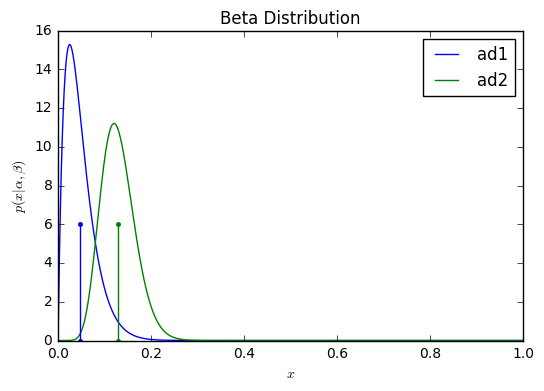

In [9]:
x = np.linspace(0, 1, 1000)  # Create 1000 points in between 0 and 1
plt.plot(x, posteriors['ad1'].pdf(x), x, posteriors['ad2'].pdf(x)); # Plot the Beta PDFs
plt.plot((data['ad1']['clicks'] *1.0 / data['ad1']['views'], # Plot the raw click rate ad1
          data['ad1']['clicks'] *1.0 / data['ad1']['views']), (0, 6), 'b.-')
plt.plot((data['ad2']['clicks'] *1.0 / data['ad2']['views'], # Plot the raw click rate ad2
          data['ad2']['clicks'] *1.0 / data['ad2']['views']), (0, 6), 'g.-')
plt.xlabel('$x$');
plt.ylabel(r'$p(x|\alpha,\beta)$');
plt.title('Beta Distribution');
plt.legend(['ad1', 'ad2']);
print ('So this is how confident we are about the click rates for these ads.')
print ('Vertical lines are the raw click rate calculations for each ad.')

## Point estimates (what is the click rate of ad1 based on current posterior distribution)

In [10]:
'''
The point estimate of the click rate is just the mean
of the distribution. However, we could also use median or
max value.
'''
def calcEstimate(adID):
    return posteriors[adID].mean()

In [11]:
print('ad1\'s click rate is estimated to be {:.3}%'.
      format(calcEstimate('ad1') * 100))

ad1's click rate is estimated to be 4.76%


In [12]:
print('ad2\'s click rate is estimated to be {:.3}%'.
      format(calcEstimate('ad2') * 100))

ad2's click rate is estimated to be 12.9%


The triangles are the estimate for the click rate based on the posterior


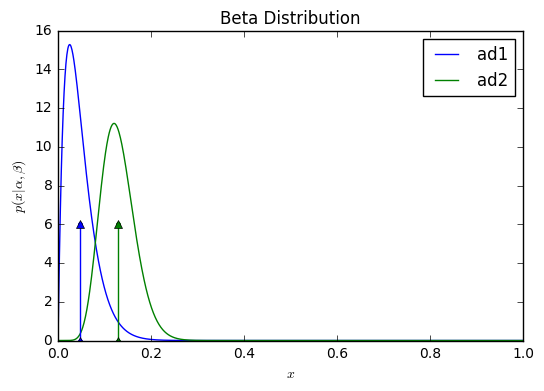

In [13]:
x = np.linspace(0, 1, 1000)  # Create 1000 points in between 0 and 1
plt.plot(x, posteriors['ad1'].pdf(x), x, posteriors['ad2'].pdf(x)); # Plot the Beta PDFs

plt.plot((data['ad1']['clicks'] *1.0/ data['ad1']['views'], # Plot the raw click rate ad1
          data['ad1']['clicks'] *1.0/ data['ad1']['views']), (0, 6), 'b.-')
plt.plot((data['ad2']['clicks'] *1.0/ data['ad2']['views'], # Plot the raw click rate ad2
          data['ad2']['clicks'] *1.0/ data['ad2']['views']), (0, 6), 'g.-')

plt.plot((calcEstimate('ad1'), calcEstimate('ad1')), (0,6), 'b^')  # Estimate from posterior
plt.plot((calcEstimate('ad2'), calcEstimate('ad2')), (0,6), 'g^')

plt.xlabel('$x$');
plt.ylabel(r'$p(x|\alpha,\beta)$');
plt.title('Beta Distribution');
plt.legend(['ad1', 'ad2']);
print ('The triangles are the estimate for the click rate based on the posterior')

## 95% Credible Interval
A credible interval is what the traditional confidence interval promised us but never could deliver. A 95% credible interval means there is a 95% chance that the true click rate is within the interval.

In [14]:
'''
Credible interval
'''
def calcCI(adID, interval=.95):
    
    i = 1.0 - interval
    lowerI = i / 2.0 # Need half of each end
    upperI =  1.0 - (i / 2.0)
    
    lowerCI = posteriors[adID].ppf(lowerI) 
    upperCI = posteriors[adID].ppf(upperI)
    
    return lowerCI, upperCI

In [15]:
lowerCI, upperCI = calcCI('ad1', .95)
print ('ad1\'s click rate is between {:.3}% and {:.3}%'.
       format(lowerCI * 100.0, upperCI * 100.0))

ad1's click rate is between 0.596% and 12.9%


In [16]:
lowerCI, upperCI = calcCI('ad2', .95)
print ('ad2\'s click rate is between {:.3}% and {:.3}%'.
       format(lowerCI * 100.0, upperCI * 100.0))

ad2's click rate is between 6.72% and 20.8%


## Monte Carlo

How can we be sure that ad2 is really clicked more than ad1? If we were to bet on it (and all businesses do), then what's our confidence level? How do we justify it to the accountants and CEO/CFOs?

To calculate our likely benefit (called **lift**) we use a Monte Carlo approach. So in the previous code, we were able to use the data we recorded to estimate a probability distribution of that data. We got 2 probability distributions: one for ad1 and one for ad2. Using these distributions, we can now generate "new" data by just interpolating the distribution. 

So the Monte Carlo simulation randomly selects combinations from the given probability distributions and compares them. The big assumption is that our original data gave us enough information to do a good job predicting the true distribution (not necessarily the true click rate for the ad, but a good probability density/mass function of the true click rate).

By combining those random trials, it can generate the **dominance**-- i.e. what percentage of time will ad2's click rate be greater than ad1's. And, it will generate the **lift**. 

In [33]:
size = 10000  # I'm going to choose 10,000 random samples

samples = { variation: posterior.rvs(size) 
           for variation, posterior in posteriors.items() }

dominance = np.mean(samples['ad2'] > samples['ad1'])

lift = np.mean((samples['ad2'] - samples['ad1']) / samples['ad1'])
    
print("I am {:.2f}% sure there's a difference between ad1 and ad2's click rates.".format(dominance*100.0))
print("I expect at least a {:.2f}% increase in click rate if I display ad2 over ad1".format(lift))

I am 94.83% sure there's a difference between ad1 and ad2's click rates.
I expect at least a 4.29% increase in click rate if I display ad2 over ad1


## What if your boss is really demanding?

Let's say you boss tells you that she'll only run ad2 if she has an assurance that it will generate at least a 31.2% increase in click rates. Maybe that's due to some cost offset of running ad2 versus ad1.

No worries. Here's the one line way of doing that:

In [34]:
def calcLiftProbability(samples, lift):
    
    return (100.0 * np.mean( (samples['ad2']- samples['ad1'])/samples['ad1'] > lift/100.0 ))

In [36]:
print("I am {:.2f}% sure I'll get a {:.1f}% increase in click rate if I display ad2 over ad1".
     format(calcLiftProbability(samples, 31.2), 31.2))

I am 88.73% sure I'll get a 31.2% increase in click rate if I display ad2 over ad1


## Here are some other lift probabilities

In [38]:
print("I am {:.2f}% sure I'll get a {:.1f}% increase in click rate if I display ad2 over ad1".
     format(calcLiftProbability(samples, 5), 5))

I am 93.97% sure I'll get a 5.0% increase in click rate if I display ad2 over ad1


In [39]:
print("I am {:.2f}% sure I'll get a {:.1f}% increase in click rate if I display ad2 over ad1".
     format(calcLiftProbability(samples, 14), 14))

I am 92.30% sure I'll get a 14.0% increase in click rate if I display ad2 over ad1


In [40]:
print("I am {:.2f}% sure I'll get a {:.1f}% increase in click rate if I display ad2 over ad1".
     format(calcLiftProbability(samples, 200), 200))

I am 51.79% sure I'll get a 200.0% increase in click rate if I display ad2 over ad1


In [41]:
print("I am {:.2f}% sure I'll get a {:.1f}% increase in click rate if I display ad2 over ad1".
     format(calcLiftProbability(samples, 1000), 1000))

I am 8.73% sure I'll get a 1000.0% increase in click rate if I display ad2 over ad1


## Let's generate a probability of all lifts we could possibly expect to get

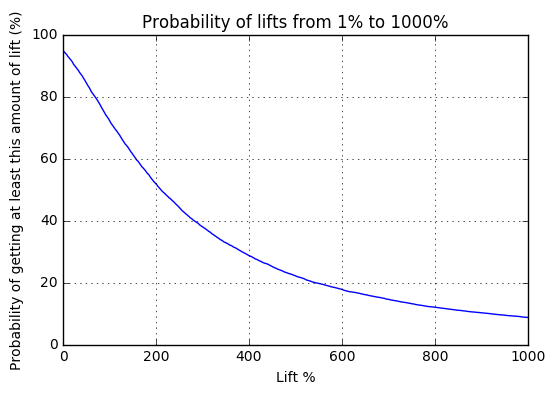

In [52]:
lift = np.linspace(1, 1000, 1000)  # Create 1000 points in between 0 and 1000
p = [calcLiftProbability(samples, l) for l in lift]

plt.plot(lift, p);
plt.title('Probability of lifts from 1% to 1000%');
plt.xlabel('Lift %');
plt.ylabel('Probability of getting at least this amount of lift (%)');
plt.grid(True);

## So even the most demanding boss would appreciate a plot like this.

It rationally shows the probability of getting a certain benefit from choosing ad2 over ad1. To emphasize the point, we not only are sure that ad2 is clicked more than ad1, we can give a reasonable guess to how much more it is clicked and even make rational decisions on whether it is cost effective to choose ad2 over ad1. That's pretty powerful.